In [1]:
# %pip install matplotlib
# %pip install tqdm  
from torch.utils.data import DataLoader
from utils.dataset import VCTKDataset
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
from src.model.cvae_tacotron_wrapper import CVAETacotron2, cvae_taco_loss
import argparse
from matplotlib import pyplot as plt
import ipywidgets
from tqdm.notebook import tqdm



In [2]:
dataset = VCTKDataset("./dataset/VCTK",)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0,
                    collate_fn=VCTKDataset.collate_cvae)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Selected speakers: ['p323', 'p301', 'p240', 'p299', 'p225', 'p285', 'p252', 'p279', 'p287', 'p311']
Speaker 0: p323: F, 19yo, SouthAfrican (Pretoria)
Speaker 1: p301: F, 23yo, American (North Carolina)
Speaker 2: p240: F, 21yo, English (Southern England)
Speaker 3: p299: F, 25yo, American (California)
Speaker 4: p225: F, 23yo, English (Southern England)
Speaker 5: p285: M, 21yo, Scottish (Edinburgh)
Speaker 6: p252: M, 22yo, Scottish (Edinburgh)
Speaker 7: p279: M, 23yo, English (Leicester)
Speaker 8: p287: M, 23yo, English (York)
Speaker 9: p311: M, 21yo, American (Iowa)
Using device: cuda


In [3]:
# # test shape
# for batch in dataloader:
#     text, text_len, mel, mel_len, gate, spk_id = batch
#     mel, gate = mel.to(device), gate.to(device)
#     spk_id = spk_id.to(device)
#     print(f"mel shape: {mel.shape}, gate shape: {gate.shape}, spk_id shape: {spk_id.shape}")
#     if mel.shape[1] != 80:
#         raise ValueError(f"Expected mel shape [B, 80, T], got {mel.shape}")
    

device = cuda


Using cache found in C:\Users\jx/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\jx/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\jx/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


[1/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1: loss 0.6409 | l1 0.594 | gate 0.047 | kl 1.14139


[2/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2: loss 0.4765 | l1 0.457 | gate 0.019 | kl 2.41098


[3/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3: loss 0.4567 | l1 0.438 | gate 0.019 | kl 2.81475


[4/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4: loss 0.4468 | l1 0.429 | gate 0.018 | kl 3.12665


[5/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5: loss 0.4413 | l1 0.424 | gate 0.018 | kl 3.36021


[6/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6: loss 0.4414 | l1 0.424 | gate 0.018 | kl 3.54591


[7/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7: loss 0.4389 | l1 0.421 | gate 0.018 | kl 3.60262


[8/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8: loss 0.4367 | l1 0.419 | gate 0.018 | kl 3.72747


[9/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9: loss 0.4415 | l1 0.424 | gate 0.018 | kl 3.87198


[10/10]:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10: loss 0.4345 | l1 0.417 | gate 0.017 | kl 3.81364


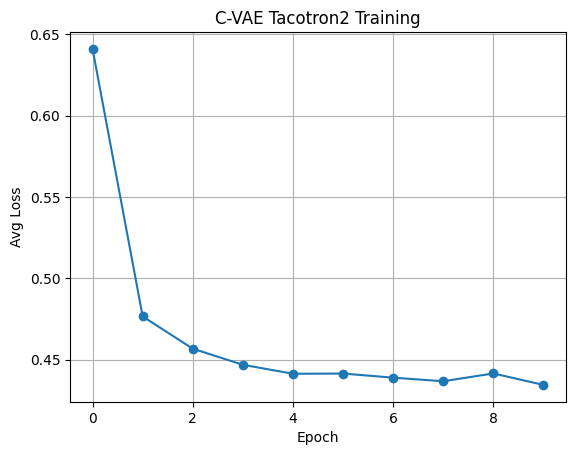

✅ saved to src\model\cvae_tacotron2_trial1.pth


In [4]:
EPOCHS      = 10
BATCH_SIZE  = 32
LR          = 2e-4           
CLIP_GRAD   = 1.0
BETA_MAX    = 1e-4
BETA_START  = 1e-6
BETA_WARMUP = 50_000       

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

model = CVAETacotron2(
    ckpt_path="src/model/check_points/tacotron2_pretrained.pt",
    z_dim=64, spk_dim_raw=256, spk_dim_proj=128
).to(device).train()

# only train the ref_enc, spk_proj, and cond_proj
trainable_params = list(model.ref_enc.parameters()) \
                 + list(model.spk_proj.parameters()) \
                 + list(model.cond_proj.parameters())
optimizer = torch.optim.AdamW(trainable_params, lr=LR, weight_decay=1e-6)

global_step = 0
loss_curve  = []

for epoch in range(1, EPOCHS+1):
    epoch_loss = 0
    l1_sum = gate_sum = kl_sum = 0

    pbar = tqdm(dataloader, desc=f"[{epoch}/{EPOCHS}]", leave=False)
    for batch in pbar:
        text, text_len, mel, mel_len, gate, spk_id = batch
        text, text_len = text.to(device), text_len.to(device)
        gate  =  gate.to(device)
        if mel.shape[1] != 80:          # [B,T,80] -> [B,80,T]
            mel = mel.permute(0, 2, 1)
        mel = mel.to(device)       
        

        # ---------- speaker embedding ----------
        spk_embed_raw = model.spk_emb[spk_id.to(device)] # [B, 256]

        # ---------- forward ----------
        mel_post, mel_out, gate_out, mu, logvar = model(
            text, text_len, mel, spk_embed_raw
        )

        # ---------- KL weight ----------
        beta = min(BETA_MAX,
                   BETA_START + global_step / BETA_WARMUP * (BETA_MAX - BETA_START))

        loss, logs = cvae_taco_loss(mel_post, mel, gate_out, gate, mu, logvar, beta=beta)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable_params, CLIP_GRAD)
        optimizer.step()

        global_step += 1
        epoch_loss += loss.item()
        l1_sum   += logs['l1']
        gate_sum += logs['gate']
        kl_sum   += logs['kl']

      
        pbar.set_postfix(loss=loss.item(), l1=logs['l1'], gate=logs['gate'], kl=logs['kl'])


    avg = lambda x: x / len(dataloader)
    print(f"Epoch {epoch}: loss {avg(epoch_loss):.4f} | "
          f"l1 {avg(l1_sum):.3f} | gate {avg(gate_sum):.3f} | kl {avg(kl_sum):.5f}")

    loss_curve.append(avg(epoch_loss))

plt.figure()
plt.plot(loss_curve, marker='o')
plt.xlabel("Epoch"); plt.ylabel("Avg Loss"); plt.title("C-VAE Tacotron2 Training"); plt.grid()
plt.show()

model_path = Path("src/model/cvae_tacotron2_trial1.pth")
torch.save(model.state_dict(), model_path)
print("✅ saved to", model_path)